Best objective: 800Minimum objective: 800
Rashomon set size: 12
Histogram entries: [(800, 12)]
Objective = 800, Count = 12

Total Rashomon trees: 12

Tree 0

Predictions from tree 0 (first 10 samples):
[1 0 0 0 0 0 1 1 1 1]

Tree 0 has 8 leaves.
All root-to-leaf paths:
[+2, +3, +10] -> 0
[+2, +3, -10] -> 1
[+2, -3, +10] -> 1
[+2, -3, -10] -> 0
[-2, +3, +10] -> 1
[-2, +3, -10] -> 0
[-2, -3, +10] -> 0
[-2, -3, -10] -> 1
 (0.08)
Objective bound: 840
Minimum objective: 800
Cache sizes - Greedy: 5555, Lickety: 437, Trie: 0, Trie cache: OFF


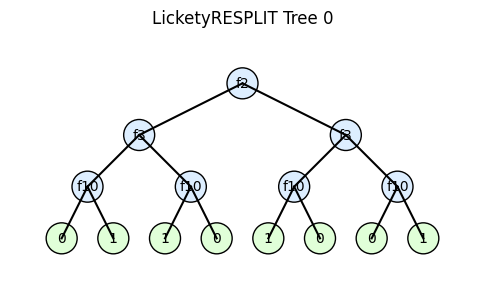

<Figure size 640x480 with 0 Axes>

Tree 11

Predictions from tree 11 (first 10 samples):
[1 0 0 0 0 0 1 1 1 1]

Tree 11 has 8 leaves.
All root-to-leaf paths:
[+10, +3, +2] -> 0
[+10, +3, -2] -> 1
[+10, -3, +2] -> 1
[+10, -3, -2] -> 0
[-10, +3, +2] -> 1
[-10, +3, -2] -> 0
[-10, -3, +2] -> 0
[-10, -3, -2] -> 1


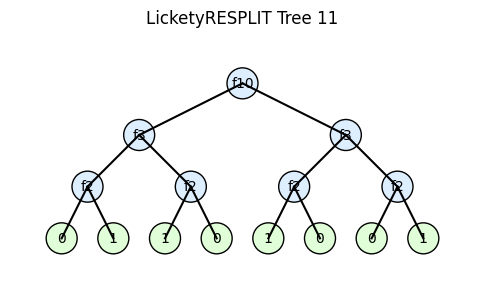

<Figure size 640x480 with 0 Axes>


[Dimensionality] Number of trees in all_preds_list: 12
[Dimensionality] Shape of first tree's prediction vector: (10000,)

[Dimensionality] Stacked prediction matrix shape (n_trees, n_samples): (12, 10000)
Majority-vote predictions (first 10 samples):
[1 0 0 0 0 0 1 1 1 1]


In [2]:
import numpy as np
from licketyresplit import LicketyRESPLIT
import matplotlib.pyplot as plt

n_samples = 10000
n_features = 10

rng = np.random.default_rng(0)

X = (rng.random((n_samples, n_features)) > 0.5).astype(np.uint8)

# label: odd/even parity of first 4 features
three_sum = X[:, 0] + X[:, 1] + X[:, 2] + X[:, 3]
y = (three_sum % 2).astype(int)

# extra feature for interest: 1 if x1 + x2 is even, 0 otherwise
sum_01 = X[:, 0] + X[:, 1]
even_01 = ((sum_01 % 2) == 0).astype(np.uint8)

X = np.hstack([X, even_01[:, None]])

model = LicketyRESPLIT()

model.fit(
    X, y,
    lambda_reg=0.01,        # sparsity penalty - recommended
    depth_budget=5,         # max tree depth as defined by number of splits along any path
    rashomon_mult=0.05,     # rashomon bound: 5% worse than initial oracle objective
    # optional parameters (default is sufficient)
    multiplicative_slack=0, # extra slack factor 
    key_mode="hash",        # "hash" for memory savings at an astronomically low change of error or "exact"
    trie_cache_enabled=False, # not recommended with hash
    lookahead_k=1, # 1 = LicketySPLIT oracle, 0 = greedy, >1 higher-tiered oracles
)

print("Minimum objective:", model.get_min_objective())
print("Rashomon set size:", model.count_trees())

hist = model.get_root_histogram()
print("Histogram entries:", hist)

for obj, cnt in hist:
    print(f"Objective = {obj}, Count = {cnt}")

# we will inspect the first and last trees
num_trees = model.count_trees()
tree_indices = [0, num_trees - 1]

print(f"\nTotal Rashomon trees: {num_trees}\n")

for tree_idx in tree_indices:
    print("=" * 60)
    print(f"Tree {tree_idx}")

    preds_i = model.get_predictions(tree_idx, X)
    print(f"\nPredictions from tree {tree_idx} (first 10 samples):")
    print(preds_i[:10])

    paths_str, preds = model.get_tree_paths_str(tree_idx)
    print(f"\nTree {tree_idx} has {len(paths_str)} leaves.")

    print("All root-to-leaf paths:")
    for s, p in zip(paths_str, preds):
        print(s, "->", p)

    fig, ax = plt.subplots(figsize=(6, 4))
    model.plot_tree(tree_idx, ax=ax)
    ax.set_title(f"LicketyRESPLIT Tree {tree_idx}")
    plt.tight_layout()
    plt.show()
    
# list-of-vectors version
all_preds_list = model.get_all_predictions(X, stack=False)
print(f"\n[Dimensionality] Number of trees in all_preds_list: {len(all_preds_list)}")
if len(all_preds_list) > 0:
    print("[Dimensionality] Shape of first tree's prediction vector:",
          all_preds_list[0].shape)

# stacked matrix version
all_preds_mat = model.get_all_predictions(X, stack=True)
print("\n[Dimensionality] Stacked prediction matrix shape (n_trees, n_samples):",
      all_preds_mat.shape)

majority_vote = (all_preds_mat.mean(axis=0) >= 0.5).astype(np.uint8)
print("Majority-vote predictions (first 10 samples):")
print(majority_vote[:10])
